In [1]:
import sys
sys.path.append('..')
from sklearn.model_selection import train_test_split

import numpy as np
import pickle
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import random
from forwardModeling import Code2EEG
from backwardModeling import Match
from utils import codeDistance
import pandas as pd
import os

In [2]:
srate = 240
expName = 'sweep'

dir = '../datasets/%s.pickle' % expName
winLENs = np.arange(0.2, 1, step=.2)
with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)

sub = wholeset[-1]

chnNames = ['PZ', 'PO5', 'POZ', 'PO4', 'PO6', 'O1', 'OZ', 'O2']
chnINX = [sub['channel'].index(i) for i in chnNames]
X = sub['wn']['X'][:, chnINX]
y = sub['wn']['y']
S = sub['wn']['STI']
sub['name']

'suxiaohan'

In [24]:
from scipy.stats import zscore
X = zscore(X,axis=-1)
evokeds = np.stack([X[y==i].mean(axis=0) for i in np.unique(y)])
evokeds = zscore(evokeds,axis=-1)

In [34]:
snrs = np.zeros((160,6,8))
N = 240
_classes = np.unique(y)
for i,(evoked,_class) in enumerate(zip(evokeds,_classes)):
    epochs = X[y==_class]
    for j,epoch in enumerate(epochs):
        residual = epoch-evoked
        for k,(chn_s, chn_n) in enumerate(zip(epoch,residual)):

            s = 1/N*(np.square(np.abs(chn_s)).sum())
            n = 1/N*(np.square(np.abs(chn_n)).sum())

            snrs[i,j,k] = s/n

In [39]:
snrs.shape

(160, 6, 8)

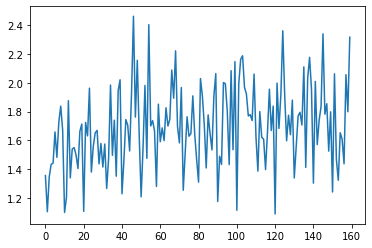

In [45]:
plt.plot(snrs.mean(axis=(1,-1)))